#### The 5th exercise sheet will introduce Biopython and should be returned to us not later than the 10.07.2016. Good luck! 

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Managing biological data with Biopython

During the last exercises you have learned a lot about python in general and how to use it to process FASTA files and plot images. In this exercise you we will use a new very powerful library called biopython that makes all of that even simpler and more robust.
http://biopython.org

### Working with sequences

The Seq object is Biopython's main representation of nucleotide or protein sequences. 
You can use it like a normal python string, but it also has additional informations, like an alphabet. Its constructor is available in the Bio.Seq module.

In [1]:
from Bio.Seq import Seq

Let's make our first Seq object.

In [3]:
my_seq = Seq('gatacagatagaaaggtt')

In [4]:
my_seq

Seq('gatacagatagaaaggtt', Alphabet())

In [5]:
from Bio.Alphabet import generic_dna
my_dna = Seq('gatacagatagaaaggtt', generic_dna)
my_dna

Seq('gatacagatagaaaggtt', DNAAlphabet())

Notice the difference between both sequences? The second one has an explicit alphabet information. 
Biopython never tries to guess what alphabet of your sequence, it has to be explicit stated  by yourself.


In [6]:
my_rna = Seq('gauacagauagaaagguu')
my_rna

Seq('gauacagauagaaagguu', Alphabet())

The Sequence object has many useful methods, many of them are derived from the main python string object, that you already know.

In [7]:
my_dna.upper()
print (my_dna.endswith('N'))
my_dna + my_dna

False


Seq('gatacagatagaaaggttgatacagatagaaaggtt', DNAAlphabet())

In [8]:
template_dna = my_dna.reverse_complement() # returns the reverse complement of the sequence
messenger_rna = my_dna.transcribe() # transcribe the coding strand into the corresponding mRNA
amino_acids = messenger_rna.translate() # translate mRNA to the corresponding amino acids
template_dna, messenger_rna, amino_acids

(Seq('aacctttctatctgtatc', DNAAlphabet()),
 Seq('gauacagauagaaagguu', RNAAlphabet()),
 Seq('DTDRKV', ExtendedIUPACProtein()))

In [9]:
# Download the protein myoglobin in ipython (MYG_HUMAN)
import requests

# create a new file and write the content from the given url, which contains the myoglobin protein sequence.
response = requests.get("http://www.ncbi.nlm.nih.gov/sviewer/viewer.cgi?tool=portal&sendto=on&log$=seqview&db=protein&dopt=fasta&sort=&val=127661&from=begin&to=end&extrafeat=984", stream=True)
with open("MYG_HUMAN.fasta", "wb") as file:
    for data in response:
        file.write(data)
file.close()

In [10]:
# Calculate the seq-length of the protein.
from Bio import SeqIO
for record in SeqIO.parse("MYG_HUMAN.fasta", "fasta"):
    print("The lenght of the protein is %i amino acids." % (len(record)))

The lenght of the protein is 154 amino acids.


E: 9.090909004211426 %
K: 12.98701286315918 %
N: 1.948051929473877 %
H: 5.844155788421631 %
A: 7.792207717895508 %
S: 4.545454502105713 %
R: 1.298701286315918 %
G: 9.740260124206543 %
V: 4.545454502105713 %
I: 5.194805145263672 %
T: 2.597402572631836 %
Q: 4.545454502105713 %
D: 5.194805145263672 %
M: 2.597402572631836 %
P: 3.246753215789795 %
C: 0.649350643157959 %
F: 4.545454502105713 %
Y: 1.298701286315918 %
L: 11.038961410522461 %
W: 1.298701286315918 %


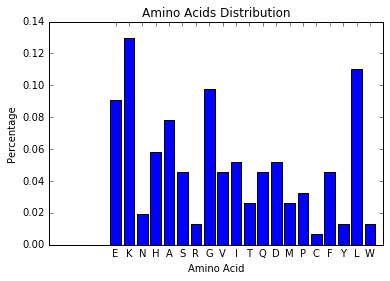

In [11]:
# Calculate the amino acid distribution and plot it.
from Bio.SeqUtils import ProtParam
import string
sequence = ProtParam.ProteinAnalysis(str(record.seq))
distr = sequence.get_amino_acids_percent()
for i in distr:
    print("{}: {} %".format(i, np.float32(distr.get(i)*100)))
X = np.arange(len(distr))
plt.bar(X, distr.values(), align='center')
plt.xticks(X, distr.keys())
ymax = max(distr.values())
plt.ylim(0, ymax + 0.01)
xlabel("Amino Acid")
ylabel("Percentage")
title("Amino Acids Distribution")
plt.show()

In [12]:
# Calculate the overall weight of that protein.
print("The overall weight of this protein is %f."%(sequence.molecular_weight()))

The overall weight of this protein is 17183.597500.


With biopython you can read many different formats, not only FASTA. For a more or less complete list, have a look at http://biopython.org/wiki/SeqIO#File_Formats.

### Let's study the microbe of the year **Nostoc** (CP002059.1)!

In [13]:
from Bio import Entrez
Entrez.email = "arber.zela21@gmail.com"
# fetch the data for Nostoc azollae:
handle = Entrez.efetch(db='nucleotide', id='CP002059.1', rettype='gb')
# create a new file to write the record and store it localy:
file = open('Nostoc azollae.gb', 'w')
file.write(handle.read())
handle.close()
file.close()

Features give the information about genes, as well as significant regions in the sequence, such as CDS for proteins and RNA molecules, UTR, variations, etc. The record includes all the information about the organism in the genbank file, such as the locus, definition, accession number, version, references and also some comments. One accession number corresponds to each record and the accession number is kept unchanged even if the author modifies the record. However, sometimes if the author combines previous sequences, or if some older version of a record is replaced with a new version, a new accession number is needed. So we need more than one record when we have more than one version. Also we include records of different organisms but which belong to the same subfamily let's say into one genbank file.

In [14]:
record = SeqIO.read(open("Nostoc azollae.gb"), "genbank")
genes, CDS = 0, 0
for feature in record.features:
    if feature.type == 'CDS':
        CDS += 1
    elif feature.type == 'gene':
        genes += 1
print("Number of CDS: %i\nNumber of genes: %i"%(CDS, genes))

Number of CDS: 3589
Number of genes: 5280


3589 CDS and 5280 genes are annotated. CDS comprises only the protein coding sequence, meanwhile the genes include all DNA sequence responsible for all its RNA's products. In the record we can see also genes responsible for some hypothetical proteins, so this is the reason why we have more genes than CDS.

In [15]:
tRNA, rRNA, ncRNA = 0, 0, 0
for feature in record.features:
    if feature.type == 'tRNA':
        tRNA += 1
    elif feature.type == 'rRNA':
        rRNA += 1
    elif feature.type == 'ncRNA':
        ncRNA += 1
print("Number of tRNA's: %i\nNumber of rRNA's: %i\nNumber of ncRNA's: %i"%(tRNA, rRNA, ncRNA))

Number of tRNA's: 44
Number of rRNA's: 12
Number of ncRNA's: 2


In [16]:
list = []
for feature in record.features:
    if feature.type == 'gene':
        list.append(len(feature.extract(record.seq)))     
gene_length = np.array(list)
print("The maximum gene length is %i."%(np.max(gene_length)))
print("The minimum gene length is %i."%(np.min(gene_length)))
print("The mean of the gene length distribution is %i."%(np.mean(gene_length)))

The maximum gene length is 9876.
The minimum gene length is 69.
The mean of the gene length distribution is 832.


Another very important quantity of a nucleotide sequence is the GC% content.
You might want to look at the GC% of all the genes in a bacterial genome for example, 
and investigate any outliers which could have been recently acquired by horizontal gene transfer. 

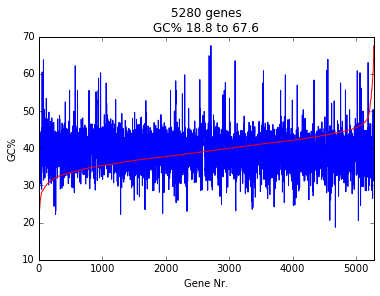

In [17]:
from Bio.SeqUtils import GC
import matplotlib.pyplot as plt
record = SeqIO.read(open("Nostoc azollae.gb"), "genbank")
GC_content = []
for feature in record.features:
    if feature.type == 'gene':
        GC_content.append(GC(feature.extract(record.seq)))  # find the GC% for the gene sequence and append it to the list.
GC_sorted_content = sorted(GC_content)  # sort the list.
plt.plot(range(len(GC_content)), GC_content, range(len(GC_content)), GC_sorted_content, 'r')  # plot the GC%
plt.title("%i genes\nGC%% %0.1f to %0.1f" % (len(GC_content),min(GC_content),max(GC_content)))
plt.xlabel('Gene Nr.')
plt.ylabel('GC%')
plt.xlim([0, len(GC_content)])
plt.show()

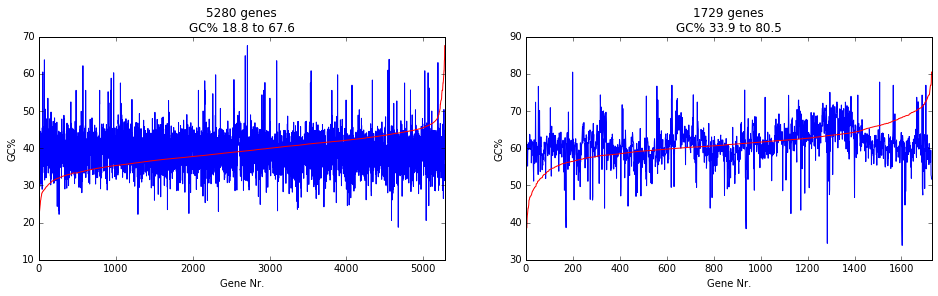

In [18]:
# !!THE ACCESSION NUMBER HAS BEEN CHANGED!!
# fetch the data for Methanopyrus kandleri:
handle = Entrez.efetch(db='nucleotide', id='AE009439.1', rettype="gb", retmode="text")
# create a new file to write the record and store it localy:
file = open('Methanopyrus kandleri.gb', 'w')
file.write(handle.read())
handle.close()
file.close()

record_2 = SeqIO.read(open("Methanopyrus kandleri.gb"), "genbank")
GC_content_2 = []
for feature in record_2.features:
    if feature.type == 'gene':
        GC_content_2.append(GC(feature.extract(record_2.seq)))  # find the GC% for the gene sequence and append it to the list.
GC_sorted_content_2 = sorted(GC_content_2)  # sort the list.
fig, axes = plt.subplots(1, 2, figsize=(16,4))
# plot the GC% for Nostoc azollae.
axes[0].plot(range(len(GC_content)), GC_content, range(len(GC_content)), GC_sorted_content, 'r')
axes[0].set_title("%i genes\nGC%% %0.1f to %0.1f" % (len(GC_content),min(GC_content),max(GC_content)))
axes[0].set_xlim([0, len(GC_content)])
axes[0].set_xlabel('Gene Nr.')
axes[0].set_ylabel('GC%')
# plot the GC% for Methanopyrus kandleri.
axes[1].plot(range(len(GC_content_2)), GC_content_2, range(len(GC_content_2)), GC_sorted_content_2, 'r')
axes[1].set_title("%i genes\nGC%% %0.1f to %0.1f" % (len(GC_content_2),min(GC_content_2),max(GC_content_2)))
axes[1].set_xlim([0, len(GC_content_2)])
axes[1].set_xlabel('Gene Nr.')
axes[1].set_ylabel('GC%')
plt.show()

Methanopyrus kandleri has less genes than Nostoc azollae but the GC content is mainly higher for each gene.

In [61]:
from Bio import SeqIO, Entrez
handle_2 = Entrez.efetch(db='nucleotide', id='NC_001422.1', rettype='fasta')
# create a new file to write the record and store it localy:
file = open('NC_001422.1.fasta', 'w')
file.write(handle_2.read())
handle_2.close()
file.close()

record = SeqIO.read("NC_001422.1.fasta", "fasta")
seq = record.seq

# creates a new fasta file as output and writes the ORF found in the input file.
ORFnumber = [0, 0, 0]
output = open('ORF.fasta', 'w')

for frame in range(3):
    # translate the nucleotide sequence into the corresponding amino acids.
    trans = str(seq[frame:].translate())
    start, end = 0, 0
    while start < len(trans):
        start = trans.find("M", start)
        end = trans.find("*", start)
        # if no more stop codons found go to the next frame.
        if end == -1:
            break
        # if length of sequence found more than 27 nucleotides (excluding stop codon) ORF found.
        elif end - start >= 9:
            start_pos = frame + start * 3
            end_pos = frame + end * 3 + 3
            orf_len = end_pos - start_pos
            output.write('>frame:{} |start position:{} |end position:{} |lenght of ORF:{} \n'.format(frame + 1, start_pos, end_pos, orf_len))
            output.write('{} \n\n'.format(seq[start_pos:end_pos]))
            ORFnumber[frame] += 1
            start = start + 1
            continue
        # else start searching after the stop codon for the next start codon.
        start = end + 1

# print the total number of ORF and for each reading frame.
for i in range(3):
    print('> Reading frame {}: {} ORF sequences.'.format(i + 1, ORFnumber[i]))
print('> Total number of ORF found: {}'.format(sum(ORFnumber)))
    
output.close()

> Reading frame 1: 42 ORF sequences.
> Reading frame 2: 24 ORF sequences.
> Reading frame 3: 38 ORF sequences.
> Total number of ORF found: 104


C:\Users\user\Anaconda3\lib\site-packages\Bio\Seq.py:2041: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning)
